# Generate RBS Recommendations

This notebook generates RBS recommendations based on the [dataset](https://github.com/synbiochem/opt-mva) provided by [paper](https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398). The goal is to find the best 6-base RBS sequence (-6 ~-12 base?) which gives the maximum translation initiation rate (TIR). 

The dataset has 56 arms with 113 data points, which each sequence is 13-base and the label is the TIR. We read the whole data as initialisation and recommend 100 arms to sample in the first round, which will be done in the biology experiment. So the 100 arms should be unique and sampled from the  whole possible arm space. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import random

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression_cp import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
from prettytable import PrettyTable
%matplotlib inline

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_list.xlsx'

df = pd.read_excel(Path, sheet_name='Unique RBS')
df.columns = ['A', 'B', 'C', 'D', 'E', 'F']
df.head()

,A,B,C,D,E,F
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,AAGTAAGCGGGGA,57706.0,NaN,AAGTAAGCGGGGA,57706.0
1,ACGATCTTAAGTAGACGCGGAAAATAATG,AAGTAGACGCGGA,613.0,NaN,AAGTAGACGCGGA,613.0
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,AAGTAAGCGCGGA,5313.0,NaN,AAGTAAGCGCGGA,5313.0
3,ACGATCTTAAGTAAACGAGGAAAATAATG,AAGTAAACGAGGA,19594.0,NaN,AAGTAAACGAGGA,19594.0
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,AAGTAGGCGAGGA,33626.0,NaN,AAGTAGGCGAGGA,33626.0


In [4]:
group_one = df[:158].drop_duplicates(subset =['B', 'C'])
group_two = df[158:].drop_duplicates(subset =['B', 'C'])

print('group one length: ', len(group_one))
print('group two length: ', len(group_two))

group one length:  57
group two length:  56


In [5]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization 
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [6]:
data_one = np.asarray(normalize(group_one)[['B', 'C']])
data_two = np.asarray(normalize(group_two)[['B', 'C']])

data = np.concatenate((data_one, data_two), axis = 0)
data.shape

(113, 2)

In [7]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# string kernel list 
nonstr_kernels = [DotProduct(), RBF()]
str_kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, 
           #WD_shift_kernel_pw
          ]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}

nonstr_embedding_name = ['onehot', 'kmer']
str_embedding_name = ['label']

str_kernel_name = {
                   spectrum_kernel_pw: 'spec',
                   mixed_spectrum_kernel_pw: 'mspec',
                   WD_kernel_pw: 'WD',
                   WD_shift_kernel_pw: 'WDshift'
                  }

test_scores = {}

num_exper = 10

## Non String Kernels

In [8]:
def run_regression_nsk(data, cp, data_key):
    for model in [KernelRidge, GaussianProcessRegressor]:
        for kernel in nonstr_kernels:
            for embedding in nonstr_embedding_name:
                key = regression_name[model] + '_' + str(kernel).split('(')[0]+ '_' + embedding
                if key not in test_scores:
                    test_scores[key] = defaultdict(list)
                reg = Regression(model(kernel = kernel), data, embedding, cp, split_idx=56)
                reg.run_k()
                test_scores[key][data_key[0]] = reg.test_scores1
                if cp and len(data_key) > 1:  
                    test_scores[key][data_key[1]] = reg.test_scores2 

In [ ]:
run_regression_nsk(data, True, ['12', '21'])    
run_regression_nsk(data_one, False, ['11'])  
run_regression_nsk(data_two, False, ['22']) 

## String Kernels

In [10]:
def run_regression_sk(data, cp, data_key):
    for model in [KernelRidge, GaussianProcessRegressor]:
        for kernel in str_kernels:
            for embedding in str_embedding_name:
                key = regression_name[model] + '_' + str_kernel_name[kernel] + '_' + embedding
                print(key)
                if key not in test_scores:
                    test_scores[key] = defaultdict(list)
                if model == KernelRidge: 
                    reg = Regression(model(kernel = kernel), data, embedding, cp, split_idx=56)
                elif model == GaussianProcessRegressor:
                    reg = Regression(model(kernel = PairwiseKernel(metric = kernel)), data, embedding, cp, split_idx=56)
                reg.run_k()
                test_scores[key][data_key[0]] = reg.test_scores1
                if cp and len(data_key) > 1:  
                    test_scores[key][data_key[1]] = reg.test_scores2 

In [11]:
run_regression_sk(data, True, ['12', '21'])    
run_regression_sk(data_one, False, ['11'])  
run_regression_sk(data_two, False, ['22']) 

KR_spec_label
KR_mspec_label
KR_WD_label
GPR_spec_label
GPR_mspec_label
GPR_WD_label
KR_spec_label
KR_mspec_label
KR_WD_label
GPR_spec_label
GPR_mspec_label
GPR_WD_label
KR_spec_label
KR_mspec_label
KR_WD_label
GPR_spec_label
GPR_mspec_label
GPR_WD_label


## Compare of Cross Prediction

In [12]:
y = defaultdict(dict)
yerr = defaultdict(dict)

for model_key, data_scores in test_scores.items():
    print(model_key)
    x = PrettyTable()
    x.field_names = ['', 'Test1', 'Test2']
    p = []
    for data_key in sorted(data_scores):
        mean = np.round(np.asarray(data_scores[data_key]).mean(),2)
        std = np.round(np.asarray(data_scores[data_key]).std(),2)
        y[data_key][model_key] = mean
        yerr[data_key][model_key] = std
        p.append(str(mean) + ' +/- ' + str(std))
    x.add_row(['Train1', p[0], p[1]]) 
    x.add_row(['Train2', p[2], p[3]]) 
    print(x)
    print()

KR_DotProduct_onehot
+--------+---------------+---------------+
|        |     Test1     |     Test2     |
+--------+---------------+---------------+
| Train1 | 0.25 +/- 0.11 | 0.21 +/- 0.01 |
| Train2 | 0.28 +/- 0.01 |  0.16 +/- 0.1 |
+--------+---------------+---------------+

KR_DotProduct_kmer
+--------+---------------+---------------+
|        |     Test1     |     Test2     |
+--------+---------------+---------------+
| Train1 | 0.27 +/- 0.11 | 0.29 +/- 0.01 |
| Train2 |  0.29 +/- 0.0 |  0.2 +/- 0.11 |
+--------+---------------+---------------+

KR_RBF_onehot
+--------+---------------+---------------+
|        |     Test1     |     Test2     |
+--------+---------------+---------------+
| Train1 | 0.25 +/- 0.13 |  0.28 +/- 0.0 |
| Train2 |  0.33 +/- 0.0 | 0.17 +/- 0.13 |
+--------+---------------+---------------+

KR_RBF_kmer
+--------+---------------+---------------+
|        |     Test1     |     Test2     |
+--------+---------------+---------------+
| Train1 | 0.26 +/- 0.11 |  

## Comare of RMSE scores

11: Train and test using group one. KFold (k= 10)  
22: Train and test using group two. KFold (k= 10)  
12: Train group one and test group two. (Using random subset of train set)  
21: Train group two and test group one. (Using random subset of train set)

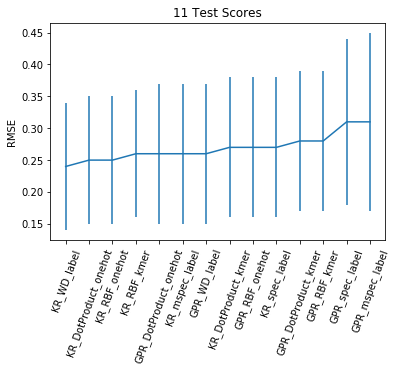

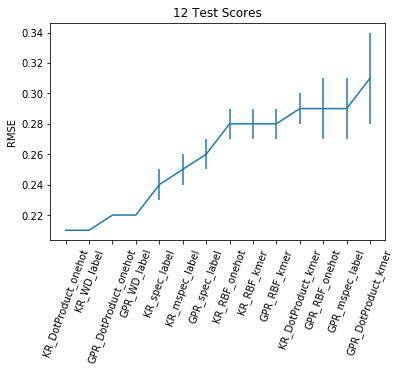

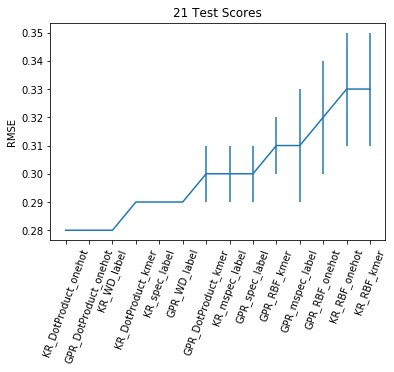

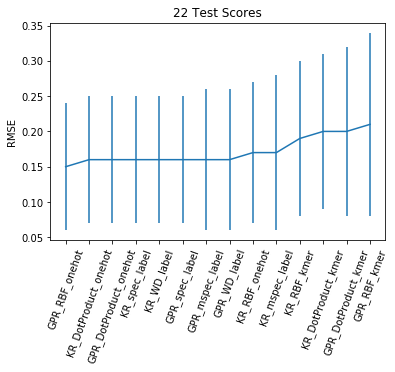

In [13]:
import collections

for data_key, scores in y.items():
    plt.figure()
    sorted_test_scores = sorted(scores.items(), key=lambda kv: kv[1])
    sorted_test_scores = collections.OrderedDict(sorted_test_scores)
    
    sorted_test_errs = sorted(yerr[data_key].items(), key=lambda kv: kv[1])
    sorted_test_errs = collections.OrderedDict(sorted_test_errs)
    
    plt.errorbar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), yerr = list(sorted_test_errs.values()))
    #plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
    plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
    plt.ylabel('RMSE')
    plt.title(data_key + ' Test Scores')
        